# 1) Data Preprocessing
In this step I prepare the data to be used for training the neural network.

The code uses a Google Ads search term report as the basis. It is also necessary to get a keyword report of each ad group to compute the average embedding of each ad group.

In [ ]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 4.0 MB/s eta 0:00:00


In [ ]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd
from tqdm import tqdm

In [ ]:
#Open csv search term report
f = "report.csv"
updated_df = pd.read_csv(f)
#Reorganize data to follow order "Search Term", "Keyword", "Added/Excluded"
updated_df = updated_df.iloc[:,[0,3,1,2]].dropna()
updated_df.head()

,Search term,Keyword,Match type,Added/Excluded
0,roof places near me,"""home roofers in my area""",Exact match,Excluded
1,arbuckle roofing,roofing companies near me,Broad match,Excluded
2,cisco roofing,roofers near me,Broad match,Excluded
3,one stop roofing,+roofing +contractor +service,Phrase match,Excluded
4,acs roofing,"""roof installation service""",Phrase match,Excluded


In [ ]:
# Get rid of match type characers in the keywords
for i in range(0,len(updated_df['Keyword'])):
  keyword = updated_df['Keyword'][i]
  if '"' in keyword:
    keyword = keyword[1:len(keyword)-1]
    updated_df['Keyword'][i] = keyword
  elif "[" in keyword:
    keyword = keyword[1:len(keyword)-1]
    updated_df['Keyword'][i] = keyword

In [ ]:
# Check updated keywords
updated_df.head()

,Search term,Keyword,Match type,Added/Excluded
0,roof places near me,home roofers in my area,Exact match,Excluded
1,arbuckle roofing,roofing companies near me,Broad match,Excluded
2,cisco roofing,roofers near me,Broad match,Excluded
3,one stop roofing,+roofing +contractor +service,Phrase match,Excluded
4,acs roofing,roof installation service,Phrase match,Excluded


In [ ]:
# Change Added/Excluded column to class numbers
for i in range(0, len(updated_df["Added/Excluded"])):
  value = updated_df["Added/Excluded"][i]
  if value == "Added":
    updated_df["Added/Excluded"][i] = 0
  elif value == "Excluded":
    updated_df["Added/Excluded"][i] = 1
  elif value == "None":
    updated_df["Added/Excluded"][i] = 2
  else:
    print("Couldn't update value")

In [ ]:
# Check mapping is correct
updated_df.head()

,Search term,Keyword,Match type,Added/Excluded
0,roof places near me,home roofers in my area,Exact match,1
1,arbuckle roofing,roofing companies near me,Broad match,1
2,cisco roofing,roofers near me,Broad match,1
3,one stop roofing,+roofing +contractor +service,Phrase match,1
4,acs roofing,roof installation service,Phrase match,1


<Axes: ylabel='Frequency'>

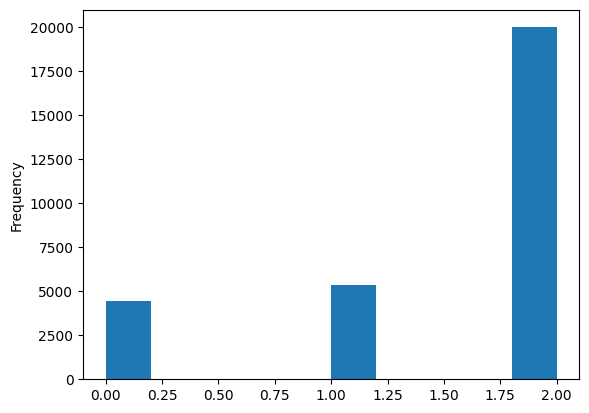

In [ ]:
# Check class distribution
updated_df['Added/Excluded'].plot.hist()

In [ ]:
# Load model to compute sentence embeddings
model = SentenceTransformer("all-mpnet-base-v2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Calculate semantic similarity for each row
# The score will go into a new DataFrame that will then be appended to the updated_df DataFrame
scores = {}
value_list = []
for i in tqdm(range(0, len(updated_df["Search term"]))):
  term_embedding = model.encode(updated_df["Search term"][i])
  keyword_embedding = model.encode(updated_df["Keyword"][i])
  value_list.append(util.pytorch_cos_sim(term_embedding, keyword_embedding).item())

100%|██████████| 29740/29740 [1:41:33<00:00,  4.88it/s]


In [ ]:
# Check results of embedding
scores["Similarity Score"] = value_list
scores_df = pd.DataFrame.from_dict(scores)
scores_df.head()

,Similarity Score
0,0.722497
1,0.583081
2,0.563198
3,0.610673
4,0.637225


In [ ]:
# Append scores_df to updated_df
updated_df = pd.concat([updated_df,scores_df], axis=1)
updated_df.head()

,Search term,Keyword,Match type,Added/Excluded,Similarity Score
0,roof places near me,home roofers in my area,Exact match,1,0.722497
1,arbuckle roofing,roofing companies near me,Broad match,1,0.583081
2,cisco roofing,roofers near me,Broad match,1,0.563198
3,one stop roofing,+roofing +contractor +service,Phrase match,1,0.610673
4,acs roofing,roof installation service,Phrase match,1,0.637225


In [ ]:
updated_df = pd.get_dummies(updated_df, prefix="Match Type", columns=["Match type"])

In [ ]:
# Create CSV file of updated report data as process backup
updated_df.to_csv("updated_report_encoded.csv")

In [ ]:
# Load previous file if backup needs to be loaded
updated_df = pd.read_csv("updated_report_encoded.csv")
updated_df = updated_df.drop("Unnamed: 0", axis=1)
updated_df.head()

,Search term,Keyword,Added/Excluded,Similarity Score,Match Type_Broad match,Match Type_Exact match,Match Type_Phrase match
0,roof places near me,home roofers in my area,1,0.722497,0,1,0
1,arbuckle roofing,roofing companies near me,1,0.583081,1,0,0
2,cisco roofing,roofers near me,1,0.563198,1,0,0
3,one stop roofing,+roofing +contractor +service,1,0.610673,0,0,1
4,acs roofing,roof installation service,1,0.637225,0,0,1


In [ ]:
# Import os utilities and create a file list
from os import listdir
folder = "ad_groups"
files = listdir(folder)
print(files)

['ad_group_7.csv', 'ad_group_2.csv', 'ad_group_1.csv', 'ad_group_8.csv', 'ad_group_11.csv', 'ad_group_6.csv', 'ad_group_5.csv', 'ad_group_10.csv', 'ad_group_12.csv', 'ad_group_13.csv', 'ad_group_3.csv', 'ad_group_4.csv', 'ad_group_9.csv']


In [ ]:
# Get average embedding for each ad group
ad_group_list = []
for f in files:
  value_list = []
  path = "ad_groups/" + f
  keyword_df = pd.read_csv(path)
  keyword_df = keyword_df[["Keyword"]].copy().dropna()
  for keyword in keyword_df["Keyword"]:
    value_list.append(model.encode(keyword))
  ad_group_list.append(sum(value_list)/len(value_list))

In [ ]:
# Compare each keyword with each ad group average and get highest similarity score

value_list = []
for term in tqdm(updated_df["Search term"]):
  term_embedding = model.encode(term)
  value = 0
  for score in ad_group_list:
    similarity = util.pytorch_cos_sim(term_embedding, score).item()
    if similarity > value:
      value = similarity
  value_list.append(value)

  0%|          | 19/29740 [00:02<54:02,  9.17it/s]


KeyboardInterrupt: 

In [ ]:
# Save keyword vs ad group score as DataFrame
value_dict = {}
value_dict["Keyword vs Account Similarity"] = value_list
value_df = pd.DataFrame.from_dict(value_dict)
value_df.head()

,Keyword vs Account Similarity
0,0.777142
1,0.650198
2,0.653079
3,0.673225
4,0.663900


In [ ]:
# Merge previous DataFrame into updated_df
updated_df = pd.concat([updated_df, value_df], axis=1)
updated_df = updated_df.iloc[:,[0,1,3,7,4,5,6,2]]
updated_df.head()

,Search term,Keyword,Similarity Score,Keyword vs Account Similarity,Match Type_Broad match,Match Type_Exact match,Match Type_Phrase match,Added/Excluded
0,roof places near me,home roofers in my area,0.722497,0.777142,0,1,0,1
1,arbuckle roofing,roofing companies near me,0.583081,0.650198,1,0,0,1
2,cisco roofing,roofers near me,0.563198,0.653079,1,0,0,1
3,one stop roofing,+roofing +contractor +service,0.610673,0.673225,0,0,1,1
4,acs roofing,roof installation service,0.637225,0.663900,0,0,1,1


In [ ]:
# Create CSV file of updated report data as process backup
updated_df.to_csv("final_report.csv")

NameError: name 'updated_df' is not defined

In [ ]:
updated_df.corr()

<ipython-input-16-ed7fd408fef4>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  updated_df.corr()


,Similarity Score,Keyword vs Account Similarity,Match Type_Broad match,Match Type_Exact match,Match Type_Phrase match,Added/Excluded
Similarity Score,1.000000,0.603199,-0.498220,0.692438,-0.108187,-0.476044
Keyword vs Account Similarity,0.603199,1.000000,-0.244658,0.326821,-0.041387,-0.265952
Match Type_Broad match,-0.498220,-0.244658,1.000000,-0.456459,-0.612267,0.227452
Match Type_Exact match,0.692438,0.326821,-0.456459,1.000000,-0.424002,-0.511523
Match Type_Phrase match,-0.108187,-0.041387,-0.612267,-0.424002,1.000000,0.223033
Added/Excluded,-0.476044,-0.265952,0.227452,-0.511523,0.223033,1.000000


In [ ]:
updated_df["Added/Excluded"].value_counts()

2    19976
1     5342
0     4422
Name: Added/Excluded, dtype: int64

In [ ]:
class_0 = updated_df["Added/Excluded"].value_counts()[0]
class_1 = updated_df["Added/Excluded"].value_counts()[1]
class_2 = updated_df["Added/Excluded"].value_counts()[2]
total = updated_df["Added/Excluded"].value_counts().sum()
print(f"Contribution: 0->{(class_0/total)*100} / 1->{(class_1/total)*100} / 2-> {(class_2/total)*100}")

Contribution: 0->14.868863483523873 / 1->17.96234028244788 / 2-> 67.16879623402825


#2) Decision tree algorithm
In this section we train a Scikit Learn tree algorithm to perform inference on the data set. We will compare the results of this with a neural network to find the best performing technology for the problem.

In [ ]:
# Map "Added", "None", "Excluded" vales as classes
key_map = {
    0:"Added",
    1:"Excluded",
    2:"None"
}

In [ ]:
# Load data backup if session is restarted
updated_df = pd.read_csv("final_report.csv")
updated_df = updated_df.drop(labels=["Unnamed: 0"], axis=1)
updated_df.head()

,Search term,Keyword,Similarity Score,Keyword vs Account Similarity,Match Type_Broad match,Match Type_Exact match,Match Type_Phrase match,Added/Excluded
0,roof places near me,home roofers in my area,0.722497,0.777142,0,1,0,1
1,arbuckle roofing,roofing companies near me,0.583081,0.650198,1,0,0,1
2,cisco roofing,roofers near me,0.563198,0.653079,1,0,0,1
3,one stop roofing,+roofing +contractor +service,0.610673,0.673225,0,0,1,1
4,acs roofing,roof installation service,0.637225,0.663900,0,0,1,1


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score

In [ ]:
# Create a classifier
criterion = "gini"
class_weights = {0: 2, 1: 2, 2:1}
tree_classifier = DecisionTreeClassifier(criterion=criterion, random_state=42)

In [ ]:
# Shrink database to have balanced class distributions
trimmed_df = updated_df.copy()
remove = trimmed_df.index[trimmed_df["Added/Excluded"] == 2]
remove = remove[:14000]
trimmed_df.drop(index=remove, inplace=True)

In [ ]:
trimmed_df["Added/Excluded"].value_counts()

2    5976
1    5342
0    4422
Name: Added/Excluded, dtype: int64

In [ ]:
# Create testing and training data
# "Similarity Score",
X = trimmed_df[["Similarity Score","Keyword vs Account Similarity","Match Type_Broad match","Match Type_Exact match","Match Type_Phrase match"]]
Y = trimmed_df["Added/Excluded"]

In [ ]:
# Create train and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [ ]:
# Train classifier
tree_classifier = tree_classifier.fit(X_train, Y_train)

In [ ]:
# Get model metadata
print("Classifier depth: ", tree_classifier.get_depth())
print("Classifier leaves: ", tree_classifier.get_n_leaves())
print("Classifier params: ", tree_classifier.get_params())

Classifier depth:  50
Classifier leaves:  2905
Classifier params:  {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}


In [ ]:
# Get model inferences for acccuracy scoring
Y_pred = tree_classifier.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print(accuracy*100)

67.85260482846252


In [ ]:
# Get model precision
precision = precision_score(Y_test, Y_pred, average="weighted")
print(precision*100)

67.59711846993594


In [ ]:
# Get feature importance
importance = tree_classifier.feature_importances_
labels = X.columns
importance_df = pd.DataFrame(data=importance, index=labels, columns=["Importance"])
importance_df.head()

,Importance
Similarity Score,0.328199
Keyword vs Account Similarity,0.353904
Match Type_Broad match,0.006590
Match Type_Exact match,0.308904
Match Type_Phrase match,0.002404


In [ ]:
import numpy as np

In [ ]:
# Test the inference with a sample not contained in the network
test_keyword = "roof replacement specialist"
test_search_term = "roof replacement contractor"

keyword_embedding1 = model.encode(test_keyword)
search_term_embedding1 = model.encode(test_search_term)
keyword_similarity = util.pytorch_cos_sim(keyword_embedding1, search_term_embedding1).item()

embedding2 = model.encode(test_search_term)
account_similarity = 0
for value in ad_group_list:
  similarity2 = util.pytorch_cos_sim(search_term_embedding1, value).item()
  if similarity2 > account_similarity:
    account_similarity = similarity2

broad_match = 1
phrase_match = 0
exact_match = 0

test_packet = [keyword_similarity, account_similarity, broad_match, phrase_match, exact_match]
test_packet = np.array(test_packet)
prediction = tree_classifier.predict(test_packet.reshape(1,-1))[0]
print("Predicted class: ", key_map[prediction])

Predicted class:  Added


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [ ]:
keyword_word_list = test_keyword.split(" ")
term_word_list = test_search_term.split(" ")
one_to_one_score = []
for word1 in keyword_word_list:
  e1 = model.encode(word1)
  top_sim = 0
  for word2 in term_word_list:
    e2 = model.encode(word2)
    one_to_one_similarity = util.pytorch_cos_sim(e1/keyword_embedding1,e2/search_term_embedding1).item()
    if one_to_one_similarity > top_sim:
      top_sim = one_to_one_similarity
      print(f"Word1: {word1} -- Word2: {word2} -- Similarity: {one_to_one_similarity}")
      one_to_one_score.append(one_to_one_similarity)

print("Complete phrase similarity: ", keyword_similarity)
print("Account similarity: ", account_similarity)
print("W2W similarity: ", sum(one_to_one_score)/len(one_to_one_score))

Word1: roof -- Word2: roof -- Similarity: 0.0006104166386649013
Word1: roof -- Word2: contractor -- Similarity: 0.0020484926644712687
Word1: replacement -- Word2: replacement -- Similarity: 0.0011862845858559012
Word1: specialist -- Word2: roof -- Similarity: 0.0016002750489860773
Complete phrase similarity:  0.8915778398513794
Account similarity:  0.7948651313781738
W2W similarity:  0.0013613672344945371


# 3) Neural Network
In this step, I implement a basic neural network using PyTorch to compare it's performance with the decision tree above.

In [ ]:
import torch
from torch import nn, optim
import torch.nn.init as init
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [ ]:
# Get the number of features
in_features = len(X_train.columns)

# Make Scikit Learn datasplits a tensor. Uses np.values to convert the dataframes into NumPy arrays before making them a tensor
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train.values, dtype=torch.long)
Y_test_tensor = torch.tensor(Y_test.values, dtype=torch.long)

#print(X_train_tensor.shape)
#print(Y_train_tensor.shape)
#print(X_test_tensor.shape)
#print(Y_test_tensor.shape)

# Create train and test dataset
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

# Create training and test DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [ ]:
# Define simple neural network
class Network(nn.Module):
  def __init__(self, in_features=5, classes=3):
    super().__init__()
    self.l1 = nn.Linear(in_features, in_features*2)
    self.l2 = nn.Linear(in_features*2, in_features*4)
    self.l3 = nn.Linear(in_features*4, in_features*8)
    self.l4 = nn.Linear(in_features*8, in_features*4)
    self.out = nn.Linear(in_features*4, classes)

    self.relu = nn.ReLU()

    self.initialize_weights()

  def forward(self, x):
    #print(x.shape)
    x = self.relu(self.l1(x))
    #print(x.shape)
    x = self.relu(self.l2(x))
    #print(x.shape)
    x = self.relu(self.l3(x))
    #print(x.shape)
    x = self.relu(self.l4(x))
    #print(x.shape)
    x = nn.Softmax(dim=1)(self.out(x))
    #print(x.shape)
    #print(x)
    return x

  def initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight)
        if m.bias is not None:
          init.constant_(m.bias, 0)

In [ ]:
# Create model instance and generate random weights
network = Network(in_features, classes=3)

# Define training parameters
epoch = 100
lr = 0.0001
criterion = nn.CrossEntropyLoss() # Error function to minimize
optimizer = optim.Adam(network.parameters(), lr, weight_decay=0.001)

100%|██████████| 100/100 [01:23<00:00,  1.19it/s]


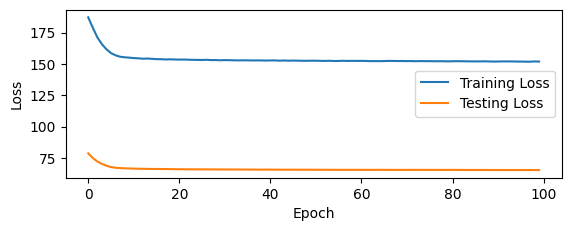

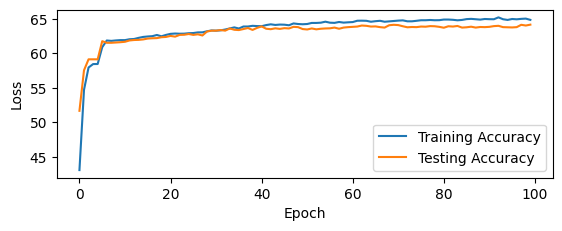

Max training accuracy: 65.20239607914323% ----- Max testing accuracy: 64.14654807285048


In [ ]:
# Create training loop
train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []

for e in tqdm(range(epoch)):
  # Puts network into training mode (that is, it will collect gradient data)
  network.train()
  train_loss = 0
  train_accuracy = 0
  correct = 0
  items = 0

  for inputs, labels in train_dataloader:
    optimizer.zero_grad() # Cleans the grad log
    outputs = network(inputs)
    loss = criterion(outputs, labels)
    loss.backward() # Calculates gradient
    optimizer.step() # Updates weights
    train_loss += loss.item()
    _, predicted = torch.max(outputs, 1) # Gets the class with the biggest probability (1 => dimension 2)
    correct += (predicted == labels).sum().item()
    items += labels.size(0)

  train_accuracy += correct/items*100
  #print(f"Training Loss: {train_loss:.4f}. Train Accuracy: {train_accuracy:.2f}%")
  train_loss_list.append(train_loss)
  train_acc_list.append(train_accuracy)

  val_loss = 0
  val_accuracy = 0
  correct = 0
  items = 0
  network.eval() # Does not track gradients to speed up compute
  for inputs, labels in test_dataloader:
    outputs = network(inputs)
    loss = criterion(outputs, labels)
    val_loss += loss.item()
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum().item()
    items += labels.size(0)

  val_accuracy += correct/items*100
  #print(f"Test Loss: {val_loss:.4f}. Test Accuracy: {val_accuracy:.2f}%")
  test_loss_list.append(val_loss)
  test_acc_list.append(val_accuracy)

plt.figure()
plt.subplot(2,1,1)
plt.plot(train_loss_list, label="Training Loss")
plt.plot(test_loss_list, label="Testing Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.subplot(2,1,2)
plt.plot(train_acc_list, label="Training Accuracy")
plt.plot(test_acc_list, label="Testing Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(f"Max training accuracy: {max(train_acc_list)}% ----- Max testing accuracy: {max(test_acc_list)}")

In [ ]:
# Perform inference with the network and the same test packet used in the tree test
test_packet = torch.tensor(test_packet, dtype=torch.float32)
print("Test Packet: ", test_packet)
print("Test Packet Shape: ", test_packet.shape)
prediction = network(test_packet.unsqueeze(0)) # .unsqueeze adds a batch dimension because softmax needs a 2d tensor
class_prediction = torch.argmax(prediction).item()
print("Predictions: ", prediction)
print("Predicted Class: ", key_map[class_prediction])
print("Prediction Shape: ", prediction.shape)

Test Packet:  tensor([0.8916, 0.7949, 1.0000, 0.0000, 0.0000])
Test Packet Shape:  torch.Size([5])
Predictions:  tensor([[0.0094, 0.0785, 0.9121]], grad_fn=<SoftmaxBackward0>)
Predicted Class:  None
Prediction Shape:  torch.Size([1, 3])


<ipython-input-246-70e0d46a7e35>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_packet = torch.tensor(test_packet, dtype=torch.float32)
